In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import glob
from scipy import stats
import pingouin as pg
import tool_box
import xarray as xr
import seaborn as sns

def correlator(pc, tmap):
    r_map = []
    for x in range(0, 36):
        temp_series = tmap[:,x]
        temp_series_no_nans = temp_series[~np.isnan(temp_series)]
        pc_non_nans = pc[~np.isnan(temp_series)]
    
        try:
            N = len(temp_series)
            r = stats.pearsonr(temp_series_no_nans[:], pc_non_nans[:])[0]
            r1_autocorrelation = stats.pearsonr(temp_series_no_nans[1:], temp_series_no_nans[:-1])[0]
            r2_autocorrelation = stats.pearsonr(pc_non_nans[1:], pc_non_nans[:-1])[0]
            N_star = N*((1-r1_autocorrelation*r2_autocorrelation)/
                        (1+r1_autocorrelation*r2_autocorrelation))
            tcrit = stats.t.ppf(1-0.025, N_star)
            t = (r*np.sqrt(N_star - 2))/(np.sqrt(1 - r**2))
            if abs(t) - tcrit > 0:
                significant = 1
            else:
                significant = 0
        except:
            r = np.NaN
            significant = 0
    
        correlation = r
        r_map.append([correlation, significant])
    return(np.transpose(r_map))

def lrt_finder(temp_prof):
    lr_temp = np.NaN
    lr_height = np.NaN
    temp_prof_1 = temp_prof[1:]
    temp_prof_2 = temp_prof[:-1]
    lr_prof_off_height = -1*(temp_prof_1 - temp_prof_2)/0.1
    lr_prof_off_height_1 = lr_prof_off_height[1:]
    lr_prof_off_height_2 = lr_prof_off_height[:-1]
    lr_prof = np.nanmean([lr_prof_off_height_1, lr_prof_off_height_2], axis=0)

    for idx in np.where(lr_prof <= 2)[0]:
        next_2km_avg_lr = np.nanmean(lr_prof[idx:idx+20])
        if next_2km_avg_lr > 2:
            continue
        elif next_2km_avg_lr <= 2:
            lr_temp = temp_prof[idx + 1]
            lr_height = idx/10 + 5.1
            break
    return(lr_temp, lr_height)

# Pull in timeseries
project_path = '/home/disk/p/aodhan/cf_physical_parameters_correlations'
cpts, cpzs, total_cf, temp_profs, profiles_cf, allTCFCalendarMaps, mjo_index, enso_index, qbo_index, bdc_mf, bdc_eddy, wv_calendar = tool_box.starter()


/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.12, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [16]:
np.shape(trop_2019_2022)

(3, 12, 72, 144, 4)

In [38]:
lrt_maps = np.array([np.load(i) for i in np.sort(glob.glob('/home/disk/p/aodhan/cf_physical_parameters_correlations/tempmaps/lrtmaps_*_c1mamb_global.npy'))])[:-2]
trop_2019_2022 = np.array([np.load(i) for i in np.sort(glob.glob('/home/bdc2/aodhan/ROwetCPTTropicsMonthlyGriddedCDACC/*TropTandZ.npy'))])

def regridder(trop_map):
    trop_map = np.array(trop_map)
    trop_map_new = []
    for lat in range(0,36):
        lat_start = lat*2
        lat_end = lat_start + 2
        lat_line = []
        for lon in range(0,72):
            lon_start = lon*2
            lon_end = lon_start + 2
            trop_selection = trop_map[:,:,lat_start:lat_end,lon_start:lon_end]
            trop_selection = np.reshape(trop_selection, (3,12,4,4))
            mean_trop_selection = np.nanmean(trop_selection, axis=2)
            lat_line.append(mean_trop_selection)
        trop_map_new.append(lat_line)
    trop_map_new = np.swapaxes(trop_map_new, 0,2)
    trop_map_new = np.swapaxes(trop_map_new, 1,3)

    return(trop_map_new)
trop_2019_2022_new = regridder(trop_2019_2022)
trop_2019_2022_new = trop_2019_2022_new[:,:,:,:,2:]

combined_trop_maps = np.concatenate([lrt_maps, trop_2019_2022_new], axis=0)
combined_trop_maps_anoms = combined_trop_maps - np.nanmean(combined_trop_maps, axis=0)
trop_maps_zm = np.nanmean(combined_trop_maps_anoms, axis=3)
print(np.shape(trop_maps_zm))


(16, 12, 36, 2)


/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice
  
/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: Mean of empty slice


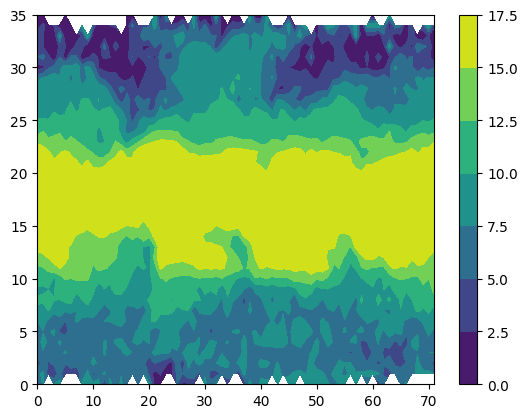

In [53]:
plt.contourf(trop_2019_2022_new[-1,1,:,:,1])
plt.colorbar()

In [39]:
lrt_anoms = np.reshape(trop_maps_zm, (16*12, 36, 2))[5:,:,0]
lrz_anoms = np.reshape(trop_maps_zm, (16*12, 36, 2))[5:,:,1]


# Large Scale Dynamics w/leads
mjo = np.load('/home/disk/p/aodhan/large_scale_dynamics/mjo_vpm_pc2_index.npy')[-187:]
Trop_upwelling = np.load(project_path + '/fileCreators/upwelling_indices/MF30NS_Trop_RegoutQBO2T500_1979_2021.npy')[-187:]
Trop_upwelling_1ml = np.load(project_path + '/fileCreators/upwelling_indices/MF30NS_Trop_RegoutQBO2T500_1979_2021.npy')[-188:-1]
qbo = np.load(project_path + '/fileCreators/u50hPa_10NS_1979_2021.npy')[-187:]
T500 = np.load(project_path + '/fileCreators/T500_15NS_500hPa_1979_2021.npy')[-187:]


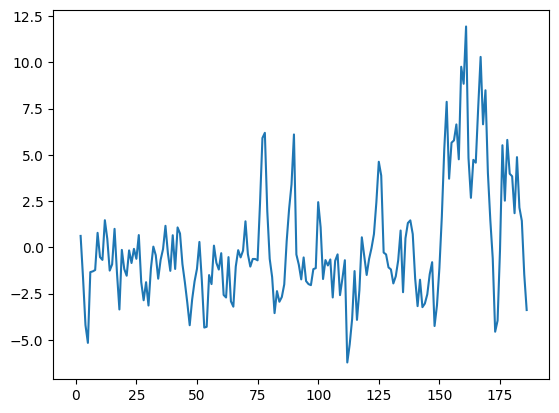

In [43]:
plt.plot(lrt_anoms[:,0])

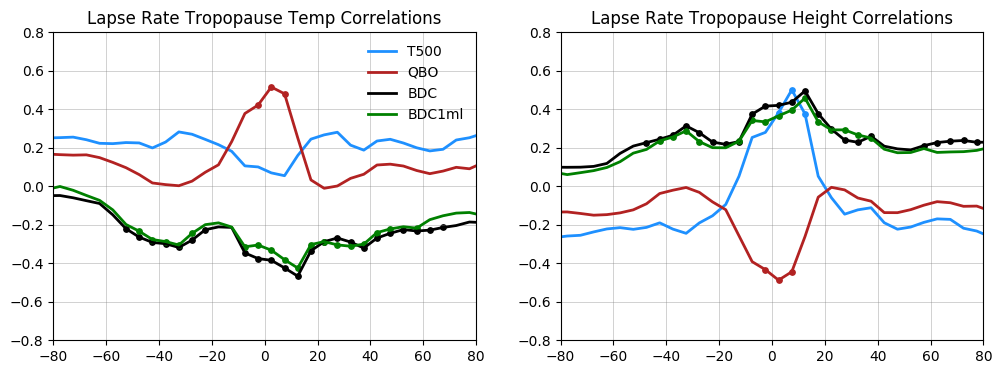

In [40]:
qbo_lrt_rmap = correlator(qbo, lrt_anoms)
bdc_lrt_rmap = correlator(Trop_upwelling, lrt_anoms)
bdc1ml_lrt_rmap = correlator(Trop_upwelling_1ml, lrt_anoms)
enso_lrt_rmap = correlator(T500, lrt_anoms)

qbo_cpt_rmap = correlator(qbo, lrz_anoms)
bdc_cpt_rmap = correlator(Trop_upwelling, lrz_anoms)
bdc1ml_cpt_rmap = correlator(Trop_upwelling_1ml, lrz_anoms)
enso_cpt_rmap = correlator(T500, lrz_anoms)

fig, axs = plt.subplots(1,2, figsize=(12,4))
lats = np.linspace(-87.5,87.5,36)

axs[0].plot(lats, enso_lrt_rmap[0], label='T500', color='dodgerblue', linewidth=2)
axs[0].plot(lats, qbo_lrt_rmap[0], label='QBO', color='firebrick', linewidth=2)
axs[0].plot(lats, bdc_lrt_rmap[0], label='BDC', color='black', linewidth=2)
axs[0].plot(lats, bdc1ml_lrt_rmap[0], label='BDC1ml', color='green', linewidth=2)
axs[0].grid(color='grey', linestyle='-', linewidth=.5, alpha=.5)
axs[0].set_ylim(-.8, .8)
axs[0].set_xlim(-80,80)
axs[0].set_title("Lapse Rate Tropopause Temp Correlations")
axs[0].legend(frameon=False)


axs[1].plot(lats, enso_cpt_rmap[0], label='T500', color='dodgerblue', linewidth=2)
axs[1].plot(lats, qbo_cpt_rmap[0], label='QBO', color='firebrick', linewidth=2)
axs[1].plot(lats, bdc_cpt_rmap[0], label='BDC', color='black', linewidth=2)
axs[1].plot(lats, bdc1ml_cpt_rmap[0], label='BDC1ml', color='green', linewidth=2)
axs[1].grid(color='grey', linestyle='-', linewidth=.5, alpha=.5)
axs[1].set_ylim(-.8, .8)
axs[1].set_xlim(-80,80)
axs[1].set_title("Lapse Rate Tropopause Height Correlations")
#axs[1].legend(frameon=False)

#axs.set_xticklabels([-90,-80,-60,-40,-20,'Eq',20,40,60,80], fontsize=14) 
#axs.set_yticklabels([-7, -.6,-.4,-.2,0,.2,.4,.6], fontsize=14) 

for i in range(36):
    if enso_lrt_rmap[1,i] == 1:
        axs[0].scatter(lats[i], enso_lrt_rmap[0,i], color='dodgerblue', s=15)
    if qbo_lrt_rmap[1,i] == 1:
        axs[0].scatter(lats[i], qbo_lrt_rmap[0,i], color='firebrick', s=15)
    if bdc_lrt_rmap[1,i] == 1:
        axs[0].scatter(lats[i], bdc_lrt_rmap[0,i], color='black', s=15)
    if bdc1ml_lrt_rmap[1,i] == 1:
        axs[0].scatter(lats[i], bdc1ml_lrt_rmap[0,i], color='green', s=15)

for i in range(36):
    if enso_cpt_rmap[1,i] == 1:
        axs[1].scatter(lats[i], enso_cpt_rmap[0,i], color='dodgerblue', s=15)
    if qbo_cpt_rmap[1,i] == 1:
        axs[1].scatter(lats[i], qbo_cpt_rmap[0,i], color='firebrick', s=15)
    if bdc_cpt_rmap[1,i] == 1:
        axs[1].scatter(lats[i], bdc_cpt_rmap[0,i], color='black', s=15)
    if bdc1ml_cpt_rmap[1,i] == 1:
        axs[1].scatter(lats[i], bdc1ml_cpt_rmap[0,i], color='green', s=15)


In [8]:
np.shape(enso_cpt_rmap)

(2, 36)

In [67]:
lrtrop_anoms = np.load(project_path + '/tempmaps/lrz_maps_anoms.npy')
cpt_anoms = np.load(project_path + '/tempmaps/cpz_maps_anoms.npy')

In [68]:
print(np.shape(cpt_anoms))

(180, 36)


In [78]:
cpts_old = [np.load(i) for i in np.sort(glob.glob('/home/disk/p/aodhan/cf_physical_parameters_correlations/tempmaps/cptmaps_*_c1mamb.npy'))]

In [80]:
cpts_new = [np.load(i) for i in np.sort(glob.glob('/home/bdc2/aodhan/ROwetCPTTropicsMonthlyGriddedCDACC/*TropTandZ.npy'))]

In [86]:
np.shape(cpts_new)

(3, 12, 24, 144, 2)

In [83]:
cpts_old_ = cpts_old[:-2]

In [ ]:
combo = 